In [53]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
train_ds, test_ds = tfds.load('mnist', split=['train', 'test'], as_supervised=True)

def prepare_mnist_data(mnist):
  #flatten the images into vectors
  mnist = mnist.map(lambda img, target: (tf.reshape(img, (-1,)), target))
  #convert data from uint8 to float32
  mnist = mnist.map(lambda img, target: (tf.cast(img, tf.float32), target))
  #sloppy input normalization, just bringing image values from range [0, 255] to [-1, 1]
  mnist = mnist.map(lambda img, target: ((img/128.)-1., target))
  #create one-hot targets
  mnist = mnist.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
  #cache this progress in memory, as there is no need to redo it; it is deterministic after all
  mnist = mnist.cache()
  #shuffle, batch, prefetch
  mnist = mnist.shuffle(1000)
  mnist = mnist.batch(32)
  mnist = mnist.prefetch(20)
  #return preprocessed dataset
  return mnist

train_dataset = train_ds.apply(prepare_mnist_data)
test_dataset = test_ds.apply(prepare_mnist_data)

In [60]:
from tensorflow.keras.layers import Dense

class MyModel(tf.keras.Model):
    
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(256, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(256, activation=tf.nn.relu)
        self.out = tf.keras.layers.Dense(10, activation=tf.nn.softmax)

    @tf.function
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.out(x)
        return x

In [56]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
   
    true_labels = np.argmax( target, axis=1) # from one-hot to labels
    predicted_labels = np.argmax( prediction , axis=1) # from model_probs to lables

    total = len(true_labels)
    correct = sum(true_labels == predicted_labels)

    acc = correct / total
    
    
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss, acc

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [59]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 10
learning_rate = 0.1

# Initialize the model.
model = MyModel()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization.
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

    #training (and checking in with training)
    epoch_loss_agg = []
    epoch_acc_agg = []
    for input,target in train_dataset:
        train_loss, train_acc = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)
        epoch_acc_agg.append(train_acc)
        
    #track training loss and accuracy
    train_losses.append(tf.reduce_mean(epoch_loss_agg))
    train_accuracies.append(np.mean(epoch_acc_agg))

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: 0 starting with accuracy 0.05830670926517572
Epoch: 1 starting with accuracy 0.9588658146964856
Epoch: 2 starting with accuracy 0.9673522364217252
Epoch: 3 starting with accuracy 0.9616613418530351
Epoch: 4 starting with accuracy 0.9736421725239617
Epoch: 5 starting with accuracy 0.9727436102236422
Epoch: 6 starting with accuracy 0.974241214057508
Epoch: 7 starting with accuracy 0.9711461661341853
Epoch: 8 starting with accuracy 0.9738418530351438
Epoch: 9 starting with accuracy 0.9733426517571885


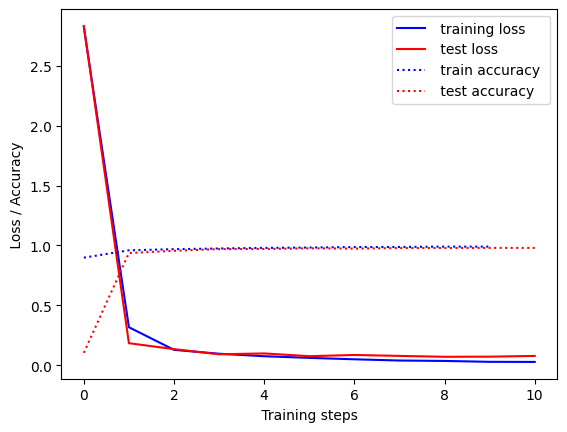

In [38]:
import matplotlib.pyplot as plt
def visualization ( train_losses , train_accuracies , test_losses ,
test_accuracies ):
 """ Visualizes accuracy and loss for training and test data using
the mean of each epoch .
 Loss is displayed in a regular line , accuracy in a dotted
line .
 Training data is displayed in blue , test data in red .
 Parameters
 ----------
 train_losses : numpy . ndarray
 training losses
 train_accuracies : numpy . ndarray
 training accuracies
 test_losses : numpy . ndarray
 test losses
 test_accuracies : numpy . ndarray
 test accuracies
 """
plt.figure()
line1 , = plt.plot( train_losses , "b-")
line2 , = plt.plot( test_losses , "r-")
line3 , = plt.plot( train_accuracies , "b:")
line4 , = plt.plot( test_accuracies , "r:")
plt.xlabel(" Training steps ")
plt.ylabel(" Loss / Accuracy ")
plt.legend(( line1 , line2 , line3 , line4 ), (" training loss ", " test loss ", " train accuracy ", " test accuracy "))
plt.show ()

Result table

| **Learning rate** | **Batch Size** | **Units per layer** | **Number of layers** | **Accuracy**  |
|-------------------|----------------|---------------------|----------------------|---------------|
| 0.1    | 32  | 256      | 2      | 0.9799321086261981 |
| 0.01    | 32  | 256      | 2       | 0.9694488817891374 |
| 0.01    | 64 | 256      | 2        | 0.962281050955414 |
| 0.1    | 64  | 256       | 2        | 0.9781050955414012 |
| 0.1     | 64  | 128      | 2       | 0.9747213375796179 |
| 0.1    | 32  | 128       | 2       | 0.9733426517571885 |
| 0.1    | 32 | 128     | 1       | 0.9690495207667732 |
| 0.1    | 32 | 256      | 1       | 0.9733426517571885 |

considering the results I have, the conclusion could be that if we remove one compelete layer we still get reletivaly good results. Decreasing learning rate could result in a drop in accuracy and increasing batch size has the same effect but not as drastically as the learning rate decrease.


